In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numba import prange, njit
import time
from mpl_toolkits.mplot3d import Axes3D
from fireworks.ic import ic_tf as fic_tf 
from fireworks.ic import ic as fic
import fireworks.nbodylib.integrators as fint
import fireworks.nbodylib.dynamics as fdyn
import fireworks.nbodylib.timesteps as ftim
from tqdm.notebook import tqdm
from fireworks.particles import Particles_tf,Particles



tf.config.optimizer.set_jit(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # Ensure TensorFlow is configured to use the GPU
assert tf.test.is_gpu_available(), "No GPU detected or TensorFlow is not configured to use it."


2024-03-29 20:41:49.217893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 20:41:49.217938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 20:41:49.219081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 20:41:49.225308: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 20:41:49.886910: W tensorflow/compiler/tf2

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


/home/draco/anaconda3/lib/python3.11/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
2024-03-29 20:41:51.498869: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-29 20:41:51.536497: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-29 20:41:51.536941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node r

In [2]:
def initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass):
    particles = fic.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass
    )
    print(f'Loaded {n_particles} particles \n')
    
    assert len(particles) == n_particles
    assert np.min(particles.pos) >= min_pos and np.max(particles.pos) <= max_pos
    assert np.min(particles.vel) >= min_vel and np.max(particles.vel) <= max_vel
    assert np.min(particles.mass) >= min_mass and np.max(particles.mass) <= max_mass
    return particles

def initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass):
    particles = fic_tf.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass
    )
    print(f'Loaded {n_particles} particles \n')
    
    assert len(particles) == n_particles
    assert tf.reduce_min(particles.pos) >= min_pos and tf.reduce_max(particles.pos) <= max_pos
    assert tf.reduce_min(particles.vel) >= min_vel and tf.reduce_max(particles.vel) <= max_vel
    assert tf.reduce_min(particles.mass) >= min_mass and tf.reduce_max(particles.mass) <= max_mass
    return particles



In [3]:
def measure_compile_time(particles, facc_list):
    compile_times = []
    for facc in facc_list:
        t1 = time.perf_counter()
        acceleration = facc(particles, softening=1e-10)
        t2 = time.perf_counter()
        dt = t2 - t1
        print(f"Time taken for acceleration using {facc.__name__}: {dt} seconds \n")
        compile_times.append(dt)
    return compile_times

def test_time_ic_random_uniform(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list):
    results = {}
    for n_particles in tqdm(N, desc=" N"):
        particles = initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
        compile_times = measure_compile_time(particles, facc_list)
        results[n_particles] = {'particles': particles, 'compile_times': compile_times}
    return results

def test_time_ic_random_uniform_tf(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list):
    results = {}
    for n_particles in tqdm(N, desc=" N_tf"):
        particles = initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
        compile_times = measure_compile_time(particles, facc_list)
        results[n_particles] = {'particles': particles, 'compile_times': compile_times}
    return results

In [4]:
# Defining initial conditions for the test
# N = np.logspace(1, 4, 15).astype(int)
N = np.linspace(10,5000,5).astype(int)
min_pos = 10.
max_pos = 100.
min_vel = 10.
max_vel = 100.
min_mass = 10.
max_mass = 100.

facc_list = [fdyn.acceleration_direct,
             fdyn.acceleration_direct_vectorized,
             fdyn.acceleration_direct_njit,
             fdyn.acceleration_direct_njit_parallel,
             fdyn.acceleration_direct_vectorized_njit]
facc_list_tf = [fdyn.acceleration_tf]


# Output Result
output_results_tf = test_time_ic_random_uniform_tf(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list_tf) 
output_results = test_time_ic_random_uniform(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list)  # For non-TensorFlow 





 N_tf:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-29 20:41:55.600692: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-29 20:41:55.600964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-29 20:41:55.601146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Loaded 10 particles 

Time taken for acceleration using acceleration_tf: 0.38924378899992007 seconds 

Loaded 1257 particles 

Time taken for acceleration using acceleration_tf: 0.0019170599998687976 seconds 

Loaded 2505 particles 

Time taken for acceleration using acceleration_tf: 0.0020109820006837253 seconds 

Loaded 3752 particles 

Time taken for acceleration using acceleration_tf: 0.0017498150000392343 seconds 

Loaded 5000 particles 

Time taken for acceleration using acceleration_tf: 0.004830812000363949 seconds 



 N:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded 10 particles 

Time taken for acceleration using acceleration_direct: 0.002289046999976563 seconds 

Time taken for acceleration using acceleration_direct_vectorized: 0.0010056999999505933 seconds 



TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /home/draco/anaconda3/lib/python3.11/site-packages/fireworks/nbodylib/dynamics.py (293)[0m
[1m
File "../../anaconda3/lib/python3.11/site-packages/fireworks/nbodylib/dynamics.py", line 293:[0m
[1mdef acceleration_tf(particles: Particles_tf, softening: float = 0.,potential: bool = False) \
    <source elided>
##################################### NUMBA JIT ##################################################################
[1m@njit
[0m[1m^[0m[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'fireworks.particles.Particles'>[0m


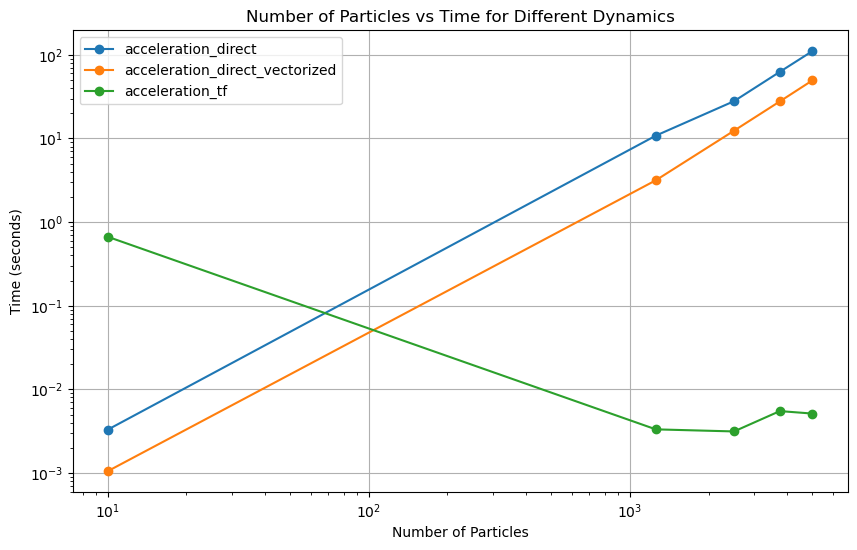

In [5]:
############################
# PLOT(N_Particle Vs Time) #
############################

plt.figure(figsize=(10, 6))

# Plotting non-TensorFlow results
for facc, label in zip(facc_list,
                       ['acceleration_direct',
                        'acceleration_direct_vectorized',
                        ]):
    times = [output_results[n]['compile_times'][facc_list.index(facc)] for n in N]
    plt.plot(N, times, marker='o', label=label)

# Plotting TensorFlow results
for facc, label in zip(facc_list_tf, ['acceleration_tf']):
    times = [output_results_tf[n]['compile_times'][facc_list_tf.index(facc)] for n in N]
    plt.plot(N, times, marker='o', label=label)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Particles')
plt.ylabel('Time (seconds)')
plt.title('Number of Particles vs Time for Different Dynamics')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def simulate_trajectory_tf(integrator, planets, dt, dynamics):
    position = []
    velocity = []
    time = []
    acceleration = []
    potential = []
    total_energy = []
    error = []
    t = 0.

    velocity.append(tf.identity(planets.vel))
    position.append(tf.identity(planets.pos))
    initial_acc = dynamics(planets)
    acceleration.append(tf.identity(initial_acc[0]) if initial_acc is not None else tf.zeros_like(planets.pos[0], dtype=tf.float64))
    total_energy.append(planets.Etot()[0])
    error.append(tf.zeros_like(planets.Etot()[0], dtype=tf.float64))
    time.append(t)
    N = 1000
    Tperiod = tf.sqrt(tf.reduce_sum(planets.mass) / tf.norm(planets.pos[0] - planets.pos[1]) ** 3)
    total_steps = int(N * Tperiod / dt)
    
    # Create tqdm progress bar
    progress_bar = tqdm(total=total_steps, desc='Simulation Progress')
    
    while t < N * Tperiod:
        t += dt
        planets, _, acc, _, pot = integrator(particles=planets, tstep=dt, acceleration_estimator=dynamics)
        Etot = planets.Etot()[0]
        Error = (Etot - total_energy[-1]) / total_energy[-1]
        position.append(tf.identity(planets.pos))
        velocity.append(tf.identity(planets.vel))
        acceleration.append(tf.identity(acc) if acc is not None else tf.zeros_like(planets.pos[0], dtype=tf.float64))
        potential.append(pot)
        total_energy.append(Etot)
        error.append(Error)
    
        time.append(t)
        progress_bar.update(1)  # Update tqdm progress bar

    position = tf.convert_to_tensor(position)
    velocity = tf.convert_to_tensor(velocity)
    acceleration = tf.convert_to_tensor(acceleration)
    potential = tf.convert_to_tensor(potential)
    time = tf.convert_to_tensor(time)
    total_energy = tf.convert_to_tensor(total_energy)
    error = tf.convert_to_tensor(error)

    progress_bar.close()  # Close tqdm progress bar

    return position, velocity, acceleration, potential, time, total_energy, error

In [7]:
def plot_trajectory(position, ax, label):
    num_particles = position.shape[1]  # Get the number of particles
    labels = [f'Particle {i + 1} - {label}' for i in range(num_particles)]

    for i in range(num_particles):
        x_particle, y_particle, z_particle = position[:, i, 0], position[:, i, 1], position[:, i, 2]
        ax.plot(x_particle, y_particle, z_particle, marker=',', label=labels[i])

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.legend(fontsize='small')


def plot_energy(total_energy, ax, label):
    ax.plot(t, total_energy, marker=',', label=f'Particle 1 - {label}')

    ax.set_xlabel('Time')
    ax.set_ylabel('Total Energy')

    ax.legend(fontsize='small')

def plot_energy_loss(error, ax, label):
    ax.plot(t, error, marker=',', label=f'Particle 1 - {label}')

    ax.set_xlabel('Time')
    ax.set_ylabel('Energy Error')

    ax.legend(fontsize='small')

def plot_2d_trajectory(position,ax,label):
    num_particles = position.shape[1]  # Assuming position has shape (time_steps, num_particles, 3)
    
    for particle_index in range(num_particles):
        x_particle, y_particle = position[:, particle_index, 0], position[:, particle_index, 1]
        ax.plot(x_particle, y_particle, marker=',', label=f'Particle {particle_index + 1} - {label}')
    
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    
    
    ax.legend(fontsize='small')


Eccentricity = [0.0, 0.5, 0.99]:   0%|          | 0/3 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/1521 [00:00<?, ?it/s]

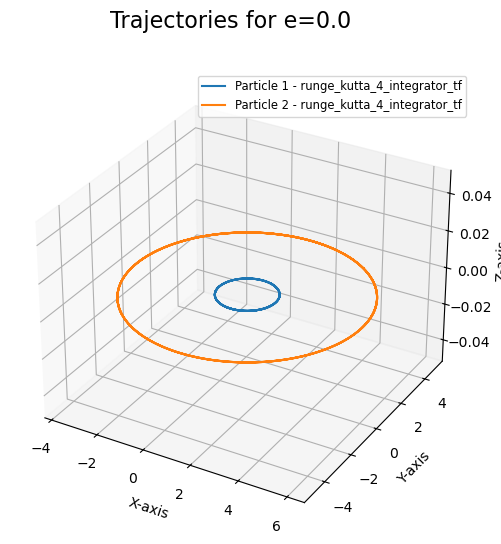

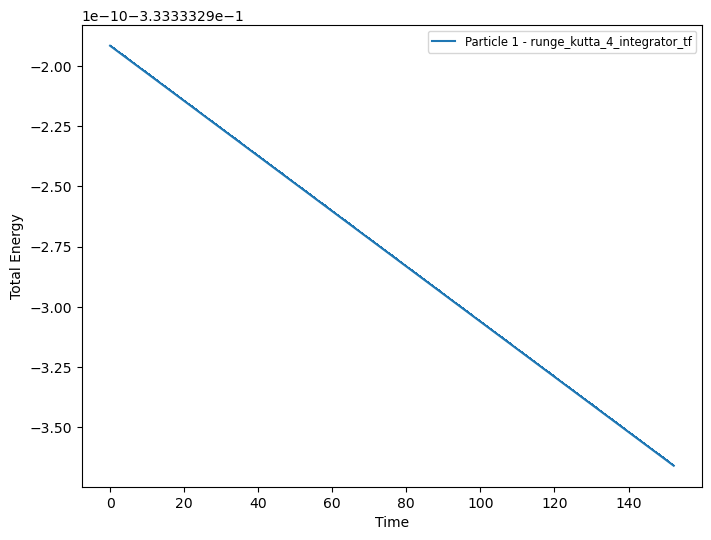

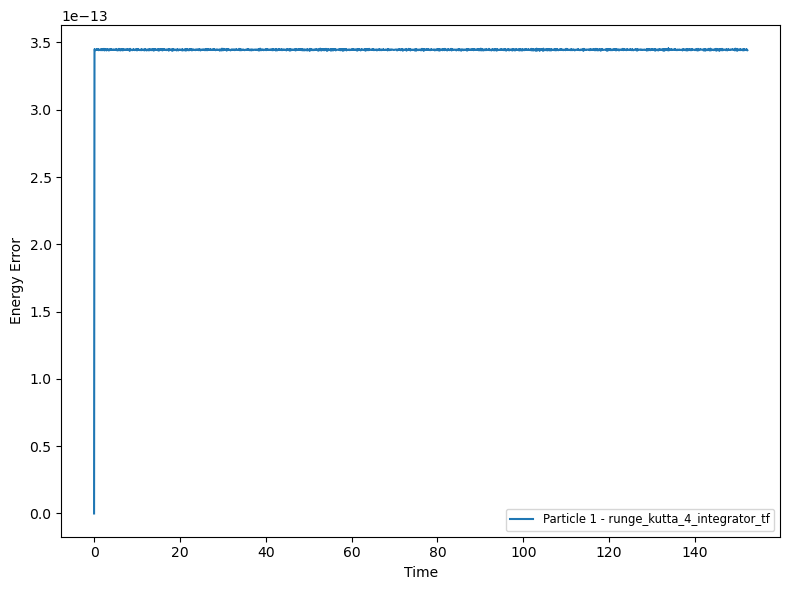

Simulation Progress:   0%|          | 0/1521 [00:00<?, ?it/s]

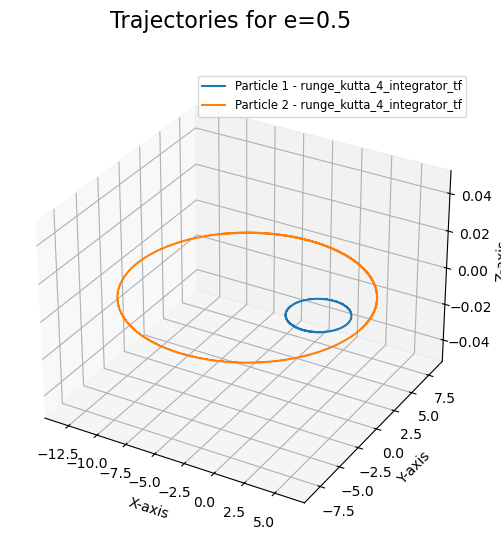

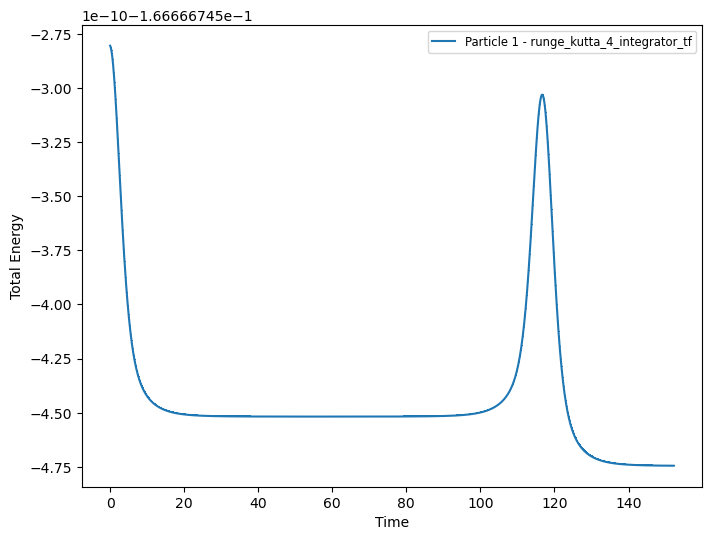

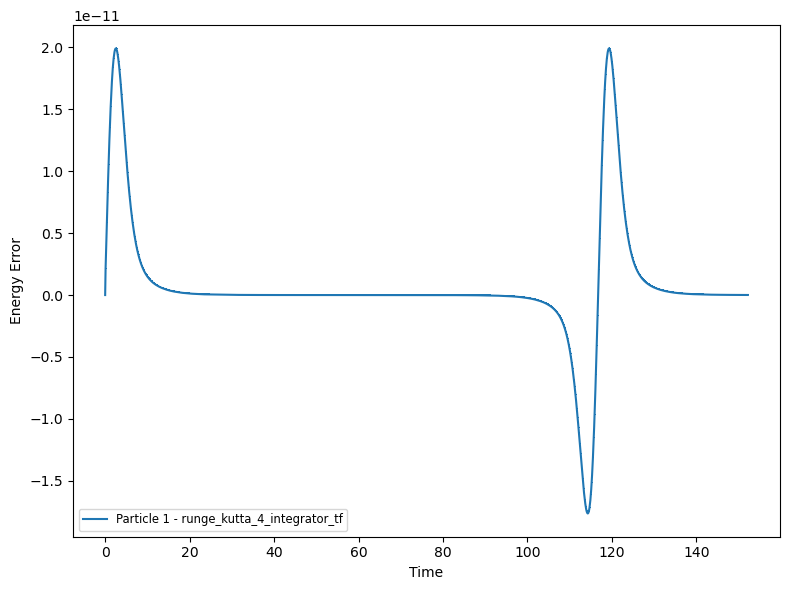

Simulation Progress:   0%|          | 0/1521 [00:00<?, ?it/s]

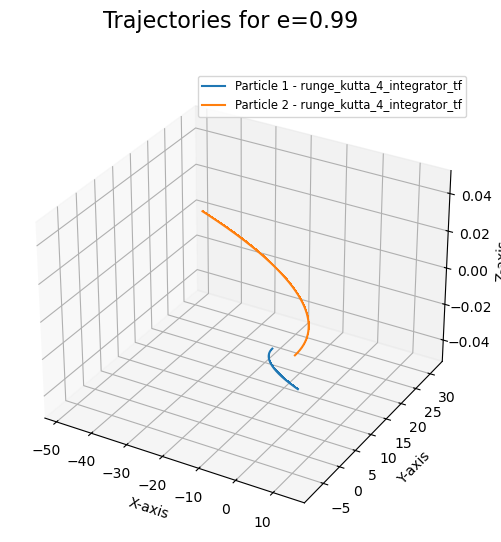

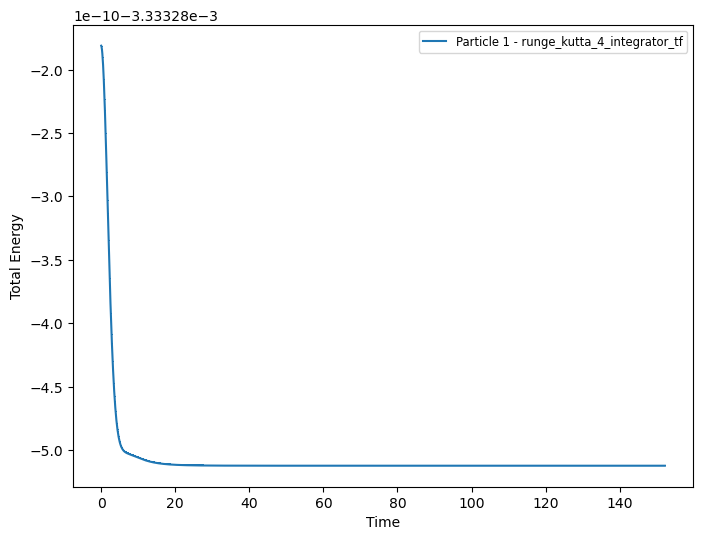

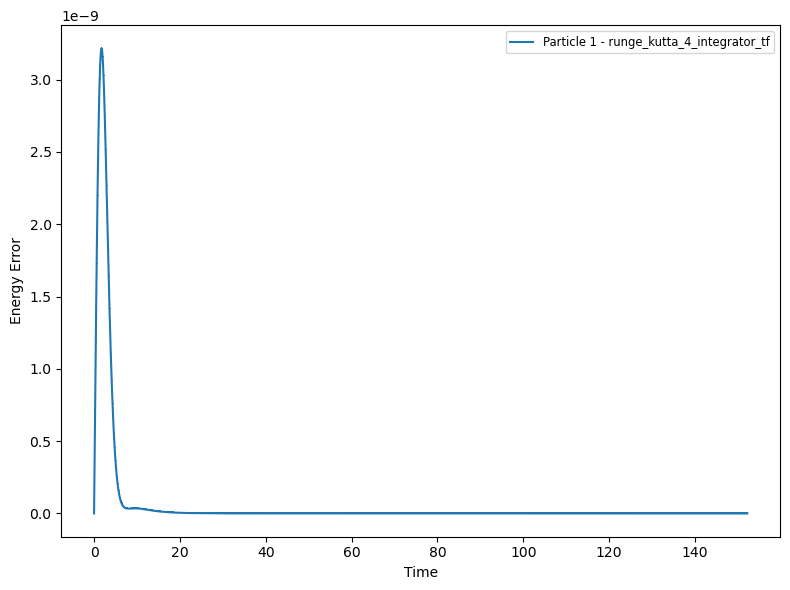

In [8]:
dt = 0.1
eccentricities = [0., 0.5, 0.99]

for e in tqdm(eccentricities, desc=f"Eccentricity = {eccentricities}"):
    fig_trajectory, ax_trajectory = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})
    fig_energy, ax_energy = plt.subplots(figsize=(8, 6))
    fig_energy_loss, ax_energy_loss = plt.subplots(figsize=(8, 6))

    planets = fic_tf.ic_two_body(mass1=4., mass2=1., rp=6., e=e)
    # planets = initialize_particles_tf(5, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
    
    position, _, _, _, t, tot_en, error = simulate_trajectory_tf(fint.runge_kutta_4_integrator_tf, planets.copy(), dt, fdyn.acceleration_tf)
    # position, _, _, _, _,_,_ = simulate_trajectory_tf(fint.runge_kutta_4_integrator_tf, planets.copy(), dt, fdyn.acceleration_tf)
    
    plot_trajectory(position.numpy(), ax_trajectory, 'runge_kutta_4_integrator_tf')
    plot_energy(tot_en.numpy(), ax_energy, 'runge_kutta_4_integrator_tf')
    plot_energy_loss(error.numpy(), ax_energy_loss, 'runge_kutta_4_integrator_tf')

    fig_trajectory.suptitle(f'Trajectories for e={e}', fontsize=16)
    # fig_energy.suptitle(f'Energy for e={e}', fontsize=16)
    # fig_energy_loss.suptitle(f'Energy Loss for e={e}', fontsize=16)

    plt.tight_layout()
    plt.show()



In [ ]:
from fireworks.particles import Particles_tf
def ic_two_body(mass1: float, mass2: float, rp: float, e: float) -> Particles_tf:
    """
    Create initial conditions for a two-body system.
    By default, the two bodies will be placed along the x-axis at the closest distance rp.
    Depending on the input eccentricity, the two bodies can be in a circular (e<1), parabolic (e=1), or hyperbolic orbit (e>1).

    :param mass1: Mass of the first body.
    :param mass2: Mass of the second body.
    :param rp: Closest orbital distance.
    :param e: Eccentricity.
    :return: An instance of the class `Particles_tf` containing the generated particles.
    """
    if not isinstance(e, float):
        raise ValueError("Eccentricity (e) must be a float.")

    Mtot = mass1 + mass2
    if e == 1.:
        vrel = tf.sqrt(2 * Mtot / rp)
    else:
        a = rp / (1 - e)
        vrel = tf.sqrt(Mtot * (2. / rp - 1. / a))
    v1 = -mass2 / Mtot * vrel
    v2 = mass1 / Mtot * vrel
    pos = tf.constant([[0., 0., 0.], [rp, 0., 0.]], dtype=tf.float64)
    vel = tf.constant([[0., v1.numpy(), 0.], [0., v2.numpy(), 0.]], dtype=tf.float64)
    mass = tf.constant([mass1, mass2], dtype=tf.float64)
    return Particles_tf(position=pos, velocity=vel, mass=mass)


In [ ]:
mass1 = 1.
mass2 = 1.
rp = 2.
e = 0.5
Mtot = mass1 + mass2
if e == 1.:
    vrel = tf.sqrt(2 * Mtot / rp)
else:
    a = rp / (1 - e)
    vrel = tf.sqrt(Mtot * (2. / rp - 1. / a))
v1 = -mass2 / Mtot * vrel
v2 = mass1 / Mtot * vrel
v1_np = v1.numpy()
v2_np = v2.numpy()

# Create the TensorFlow constant with NumPy arrays
tf.constant([[0., v1_np, 0.], [0., v2_np, 0.]], dtype=tf.float64)


In [11]:
planets = fic_tf.ic_two_body(mass1=8., mass2=1., rp=4., e=0.9)

In [12]:
planets.Epot_tf()

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

In [13]:
planets.Epot()

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

In [5]:

def simulate_trajectory_tf(integrator, planets, dt, dynamics):
    # Initialize lists to store trajectory data
    trajectory_data = []

    # Initialize progress bar
    Tperiod = tf.sqrt(tf.reduce_sum(planets.mass) / tf.norm(planets.pos[0] - planets.pos[1]) ** 3)
    
    total_steps = int(1000 * Tperiod / dt)
    progress_bar = tqdm(total=total_steps, desc='Simulation Progress')

    # Start TensorFlow Profiler
    tf.profiler.experimental.start('logdir')
    
    # Initial state
    t = 0.
    velocity = tf.identity(planets.vel)
    position = tf.identity(planets.pos)
    acceleration = tf.identity(dynamics(planets)[0]) if dynamics(planets) is not None else tf.zeros_like(planets.pos[0], dtype=tf.float64)
    potential = 0.
    total_energy = planets.Etot()[0]
    error = 0.

    trajectory_data.append((position, velocity, acceleration, potential, total_energy, error, t))

    # Simulation loop
    while t < 1000 * Tperiod:
        t += dt

        # Perform integration step
        planets, _, acc, _, pot = integrator(particles=planets, tstep=dt, acceleration_estimator=dynamics)

        # Compute total energy and error
        Etot = planets.Etot()[0]
        Error = (Etot - total_energy) / total_energy

        # Append trajectory data
        trajectory_data.append((planets.pos, planets.vel, acc if acc is not None else tf.zeros_like(planets.pos[0], dtype=tf.float64), pot, Etot, Error, t))

        # Update progress bar
        progress_bar.update(1)

    # Close progress bar
    progress_bar.close()

    # Stop TensorFlow Profiler
    tf.profiler.experimental.stop()

    # Save profile data
    tf.profiler.experimental.save('logdir')
    return trajectory_data


In [ ]:
dt = 0.1
eccentricities = [0.]#, 0.5, 0.99]

for e in tqdm(eccentricities, desc=f"Eccentricity = {eccentricities}"):
    fig_trajectory, ax_trajectory = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})
    fig_energy, ax_energy = plt.subplots(figsize=(8, 6))
    fig_energy_loss, ax_energy_loss = plt.subplots(figsize=(8, 6))

    planets = fic_tf.ic_two_body(mass1=1., mass2=1., rp=2., e=e)
    
    position, _, _, _, t, tot_en, error = simulate_trajectory_tf(fint.runge_kutta_4_integrator_tf, planets.copy(), dt, fdyn.acceleration_tf)
    plot_trajectory(position.numpy(), ax_trajectory, 'runge_kutta_4_integrator_tf')
    plot_energy(tot_en.numpy(), ax_energy, 'runge_kutta_4_integrator_tf')
    plot_energy_loss(error.numpy(), ax_energy_loss, 'runge_kutta_4_integrator_tf')

    fig_trajectory.suptitle(f'Trajectories for e={e}', fontsize=16)
    fig_energy.suptitle(f'Energy for e={e}', fontsize=16)
    fig_energy_loss.suptitle(f'Energy Loss for e={e}', fontsize=16)

    plt.tight_layout()
    plt.show()



Eccentricity = [0.0]:   0%|          | 0/1 [00:00<?, ?it/s]

Simulation Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-03-21 03:50:27.995498: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-21 03:50:27.995539: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


In [5]:
position = np.array([[1.,1.,1.],[2.,2.,2.],[3.,3.,3.]])

In [8]:
position.shape

(3, 3)

In [ ]:
@njit
def acceleration_direct_fast(pos,mass,N,softening):
    jerk = None
    pot = None

    # acc[i,:] ax,ay,az of particle i 
    #acc  = np.zeros([N,3])
    acc = np.zeros_like(pos)

    for i in range(N-1):
        for j in range(i+1,N):
            # Compute relative acceleration given
            # position of particle i and j
            mass_1 = mass[i]
            mass_2 = mass[j]

            # Compute acceleration of particle i due to particle j
            position_1=pos[i,:]
            position_2=pos[j,:]
            
            # Cartesian component of the i,j particles distance
            dx = position_1[0] - position_2[0]
            dy = position_1[1] - position_2[1]
            dz = position_1[2] - position_2[2]
            

            # Distance module
            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Cartesian component of the i,j force
            acceleration = np.zeros(3)
            acceleration[0] = -mass_2 * (5*softening**2 + 2*r**2) * dx / (2*(r**2 + softening**2)**(5/2))
            acceleration[1] = -mass_2 * (5*softening**2 + 2*r**2) * dy / (2*(r**2 + softening**2)**(5/2))
            acceleration[2] = -mass_2 * (5*softening**2 + 2*r**2) * dz / (2*(r**2 + softening**2)**(5/2))

            # Update array with accelerations
            acc[i,:] += acceleration
            acc[j,:] -= mass_1 * acceleration / mass_2 # because acc_2nbody already multiply by m[j]
        
    return (acc,jerk,pot)

@njit
def fast_acceleration_direct_vectorized(pos,N_particles,mass,softening):
   
    dx = pos[:, 0].copy().reshape(N_particles, 1) - pos[:, 0] #broadcasting of (N,) on (N,1) array, obtain distance along x in an (N,N) matrix
    dy = pos[:, 1].copy().reshape(N_particles, 1) - pos[:, 1] 
    dz = pos[:, 2].copy().reshape(N_particles, 1) - pos[:, 2] 
      
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    #r[r==0]=1 not supported on numba
    r += np.eye(r.shape[0])
    
    dpos = np.concatenate((dx, dy, dz)).copy().reshape((3,N_particles,N_particles)) 
    acc = - np.sum(dpos* (5*softening**2 + 2*r**2)/(2*(r**2 + softening**2)**(5/2)) * mass,axis=2).T
   
    jerk= None
    pot = None

    return acc, jerk, pot



@njit(parallel=True)
def parallel_acceleration_direct_fast(pos,mass,N,softening):
    jerk = None
    pot = None

    # acc[i,:] ax,ay,az of particle i 
    #acc  = np.zeros([N,3])
    acc = np.zeros_like(pos)

    for i in prange(N-1):
        for j in range(i+1,N):
            # Compute relative acceleration given
            # position of particle i and j
            mass_1 = mass[i]
            mass_2 = mass[j]

            # Compute acceleration of particle i due to particle j
            position_1=pos[i,:]
            position_2=pos[j,:]
            
            # Cartesian component of the i,j particles distance
            dx = position_1[0] - position_2[0]
            dy = position_1[1] - position_2[1]
            dz = position_1[2] - position_2[2]
            

            # Distance module
            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Cartesian component of the i,j force
            acceleration = np.zeros(3)
            acceleration[0] = -mass_2 * (5*softening**2 + 2*r**2) * dx / (2*(r**2 + softening**2)**(5/2))
            acceleration[1] = -mass_2 * (5*softening**2 + 2*r**2) * dy / (2*(r**2 + softening**2)**(5/2))
            acceleration[2] = -mass_2 * (5*softening**2 + 2*r**2) * dz / (2*(r**2 + softening**2)**(5/2))

            # Update array with accelerations
            acc[i,:] += acceleration
            acc[j,:] -= mass_1 * acceleration / mass_2 # because acc_2nbody already multiply by m[j]
        
    return (acc,jerk,pot)